In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import pycbc
import sys
sys.path.append('/home/anirudh.nemmani/git_repos/teobresums/Python/') #TEOBResumS module path
import EOBRun_module
sys.path.append('/home/anirudh.nemmani/git_repos/gweat/src/') #GWEAT module path
import TEOBResumS_utils as ecc_gen
import eccentric_source as ecc_sou
from pesummary.io import read

sys.path.append('/home/anirudh.nemmani/git_repos/GWMAT/src/') # GWMAT module path
import py_lgw
lgw = py_lgw.lensed_wf_gen()
from scipy.interpolate import interp1d

In [2]:
# Reading GW150914 parameters

gw150914 = read('../imrct/ground-150914/data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5') # Path to GWTC posterior samples
gw150914_result = gw150914.samples_dict['C01:IMRPhenomXPHM']
gw150914_pe_res = dict()
idx = np.argmax(gw150914_result['log_likelihood'])
for key in gw150914_result.keys():
            val = gw150914_result[key][idx]
            gw150914_pe_res[key] = np.float64(val)

2023-08-31  15:37:04 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-08-31  15:37:04 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-08-31  15:37:04 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


In [3]:
# Converting j-frame to l-frame
# Tilts are taken to be zero which is default in GWMAT
spins = lgw.jframe_to_l0frame(gw150914_pe_res['mass_1'], gw150914_pe_res['mass_2'], 20, phi_ref=gw150914_pe_res['phase'], 
                             theta_jn = gw150914_pe_res['theta_jn'], phi_jl=gw150914_pe_res['phi_jl'],
                             a_1=gw150914_pe_res['a_1'], a_2=gw150914_pe_res['a_2'], phi_12 = gw150914_pe_res['phi_12'])

for keys in spins.keys():
    print('%s : %s'%(keys, spins[keys]))

inclination : 2.491015454676615
spin1x : -0.0
spin1y : 0.0
spin1z : 0.8608417198511092
spin2x : -0.0
spin2y : 0.0
spin2z : 0.7195088134379835


# Defining the parameters

In [4]:
sampling_frequency = 4096
f_start = 8  # starting frequency of WF, i.e., (2,2) mode of the WF.
f_low = 20    # Lower frequency from where SNR will be computed. It should satisfy the condition, f_start <= f_low, for it to make sense.
f_ref = 20.
f_high = None
df = 0.25 
init_pars = dict(f_start=f_start, f_low=f_low, f_high=f_high, f_ref=f_ref, sample_rate=sampling_frequency, ifo_list=['H1','L1'], wf_approximant='IMRPhenomXPHM', df=df)

cbc_pars = dict(mass_1=gw150914_pe_res['mass_1'], mass_2=gw150914_pe_res['mass_2'], chi1z=0, chi2z=0, 
              inclination=spins['inclination'], coa_phase=gw150914_pe_res['phase'], polarization=gw150914_pe_res['psi'], ra=gw150914_pe_res['ra'], dec=gw150914_pe_res['dec'], 
              luminosity_distance=gw150914_pe_res['luminosity_distance'], trigger_time=gw150914_pe_res['geocent_time'],
              ecc=0.001)
#psd_pars = dict(Noise=False, gen_seed=10, psd_L1='O4')
# ode_pars = dict(ode_abstol=1e-13, ode_reltol=1e-13)

prms = {**init_pars, **cbc_pars}#, **ode_pars, **psd_pars
pars = ecc_gen.teobresums_pars_update(prms)

# Generating the time domain waveform using gweat sim_ecc_noisy_wf_gen_with_snr in TEOBUtils, since it does tappering and the previous notebook projection_teobresums.ipynb showed it's correct

In [5]:
wfs_res = ecc_gen.sim_ecc_noisy_wf_gen_with_snr(**pars)

t_hp_e = wfs_res['pure_polarized_wfs']['hp']
t_hc_e = wfs_res['pure_polarized_wfs']['hc']

f_hp = t_hp_e.to_frequencyseries(delta_f=t_hp_e.delta_f)
f_hc = t_hc_e.to_frequencyseries(delta_f=t_hc_e.delta_f)

In [6]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(t_hp_e.sample_times, t_hp_e, label=r'$h_{+}$')
sub_figure_1.plot(t_hc_e.sample_times, t_hc_e, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(f_hp.sample_frequencies, np.abs(f_hp), label=r'$h_{+}$')
sub_figure_2.loglog(f_hc.sample_frequencies, np.abs(f_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(f_hp.sample_frequencies, np.angle(f_hp), label=r'$h_{+}$')
sub_figure_3.plot(f_hc.sample_frequencies, np.angle(f_hc), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

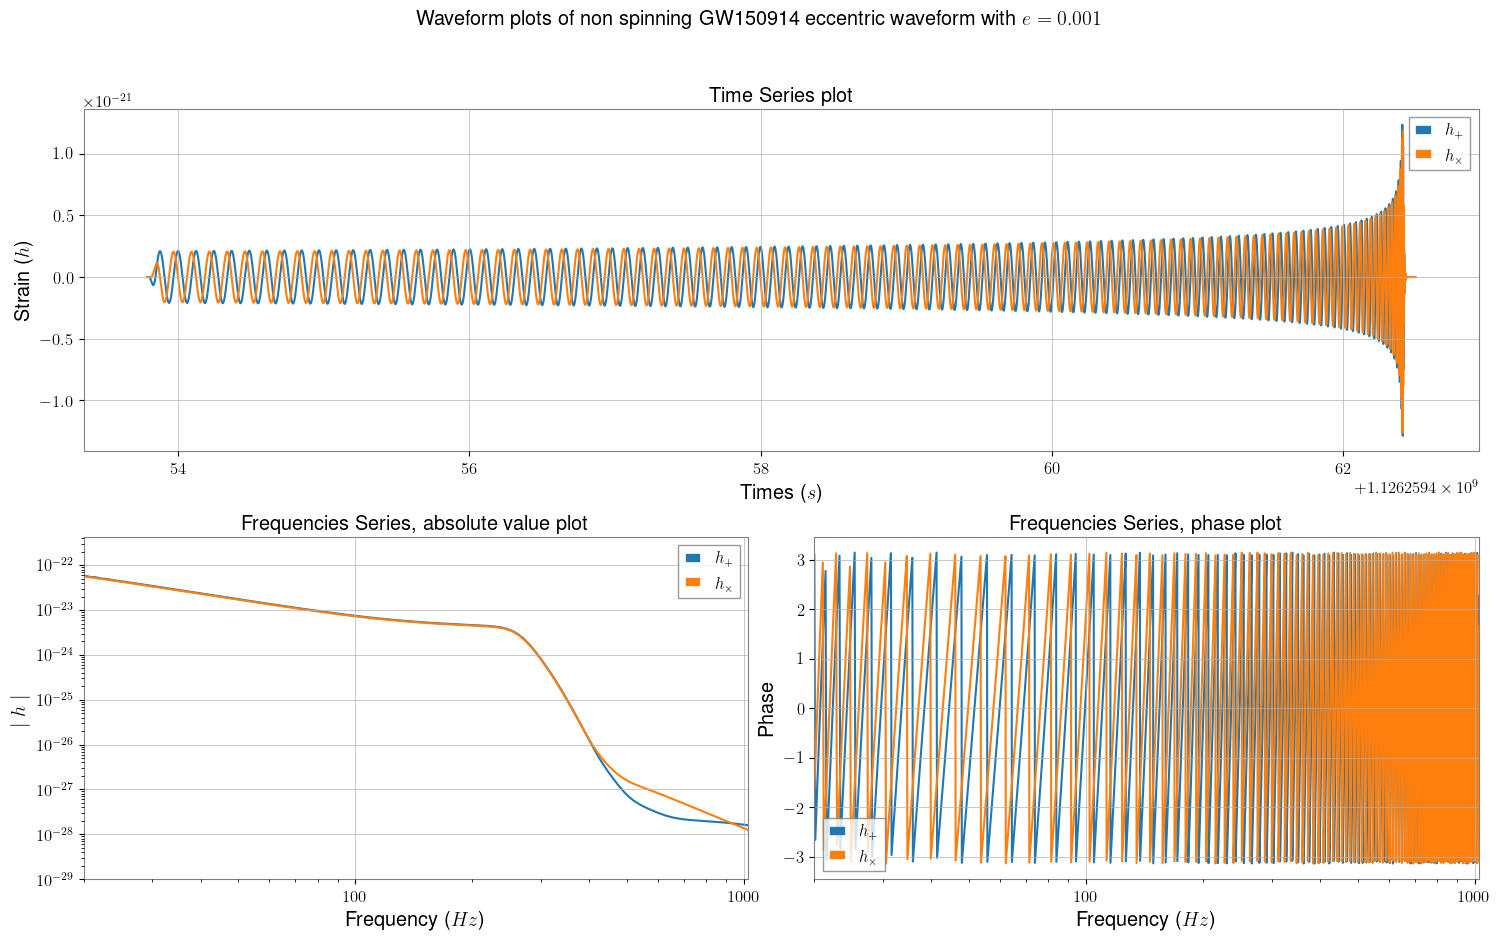

In [7]:
plt.show()

# Let's interpolate them using anuj's function

In [8]:
def eccentric_TEOBResumS_BBH_FD(frequency_array, wfs_res): 

    res = dict()
    for k in wfs_res.keys():
        wf = wfs_res[k]
        ## converting TD WF -> FD WF 
        fd_wf = wf.to_frequencyseries(delta_f=wf.delta_f)
        ## interpolating for given freqeuncy array
        fd_wf_arr = np.log10(np.array(fd_wf, dtype=np.complex128))
        ifd_wf = interp1d(fd_wf.sample_frequencies[:], fd_wf_arr[:], kind='linear')
        fd_wf_arr = np.concatenate(([0], 10**ifd_wf(frequency_array[1:])))
        #frequency_bounds = (frequency_array >=frequency_array['minimum_frequency']) * (frequency_array <= waveform_kwargs['maximum_frequency'])
        frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= frequency_array[-1])
        fd_wf_arr *= frequency_bounds

        assert len(fd_wf_arr) == len(frequency_array), 'length mismatch between the required Bilby frequency array and TEOBResumS output'

        res[k] = fd_wf_arr
    return res

In [9]:
frequency_vector = np.arange(0, 1024, 0.01)
waveforms = dict(plus = wfs_res['pure_polarized_wfs']['hp'], cross = wfs_res['pure_polarized_wfs']['hc'])

In [10]:
interpolated = eccentric_TEOBResumS_BBH_FD(frequency_vector, waveforms)

In [13]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated['plus']), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated['cross']), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated['plus']), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated['cross']), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

Text(0.5, 0.98, 'Interpolated waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

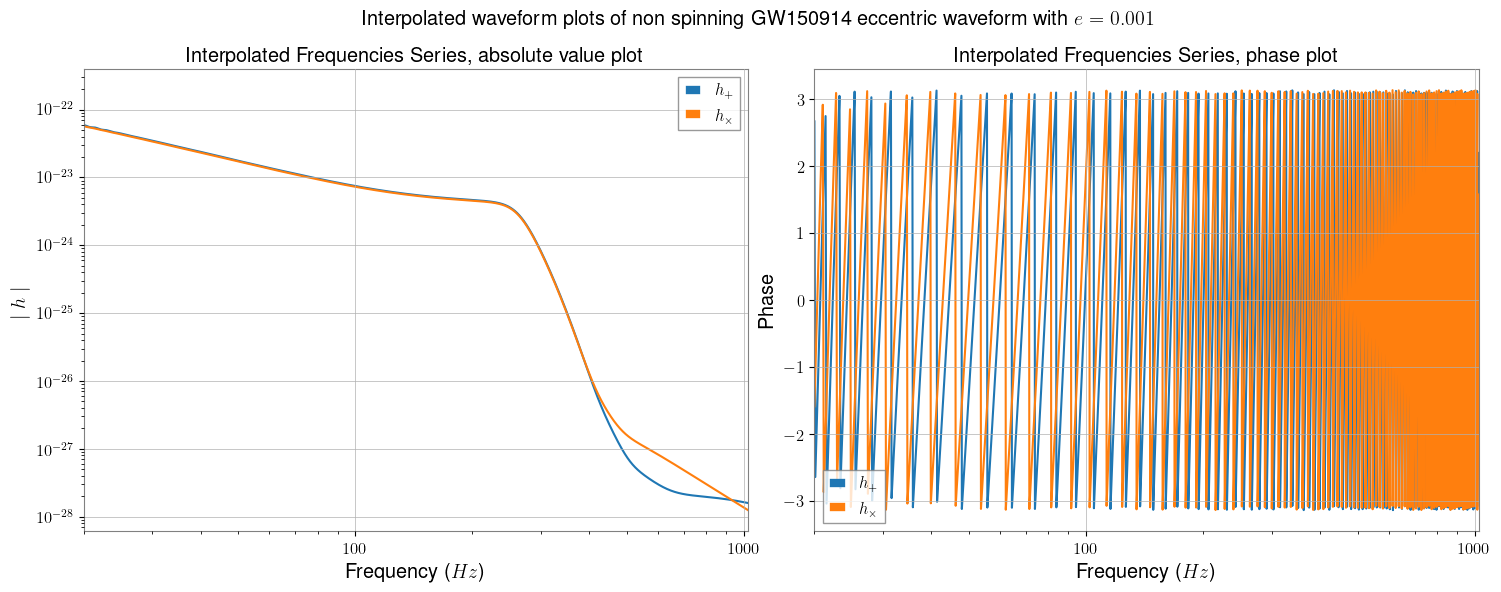

In [14]:
plt.show()

# Is the difference coming from the cyclic time shift?

In [30]:
from pycbc.waveform import utils
def cyclic_time_shift_of_WF(wf, rwrap=0):
        # This function does cyclic time shift of a WF.
        # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
        if rwrap is not None and rwrap != 0:
            sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
            cycles = int(sn/len(wf))

            cyclic_shifted_wf = wf.copy()

            sn_new = sn - int(cycles * len(wf))

            if rwrap > 0:
                epoch = wf.sample_times[0] - sn_new * wf.delta_t
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[-sn_new:]
                    tmp_wf_p2 = wf_arr[:-sn_new] 
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
            else:
                epoch = wf.sample_times[sn_new]
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[sn_new:] 
                    tmp_wf_p2 = wf_arr[:sn_new]
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

            for i in range(cycles):        
                    epoch = epoch - np.sign(rwrap)*wf.duration
                    wf_arr = np.array(cyclic_shifted_wf)[:]
                    cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

            assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
            return cyclic_shifted_wf
        else:
            return wf
        
def determine_time_shift(wf):
    wf_dt = wf.sample_times[1] - wf.sample_times[0]
    wf_end_time = wf.sample_times[-1] + wf_dt
    peak_time = wf.sample_times[np.argmax(np.array(wf))]
    t_shift = wf_end_time - peak_time
    return t_shift

In [41]:
def eccentric_TEOBResumS_BBH_FD_v2(frequency_array, wfs): 
    
    hp, hc = wfs['plus'], wfs['cross']
    wf = hp + 1j * hc
    wf = cyclic_time_shift_of_WF(wf, rwrap=determine_time_shift(wf))
    wf.start_time=0
    hp, hc = wf.real(), wf.imag()
    wf.start_time=0
    hp, hc = wf.real(), wf.imag()
    wfs_res = dict(plus = hp, cross = hc)
    res=dict()
    for k in wfs_res.keys():
        wf = wfs_res[k]
        ## converting TD WF -> FD WF 
        fd_wf = wf.to_frequencyseries(delta_f=wf.delta_f)
        ## interpolating for given freqeuncy array
        fd_wf_arr = np.log10(np.array(fd_wf, dtype=np.complex128))
        ifd_wf = interp1d(fd_wf.sample_frequencies[:], fd_wf_arr[:], kind='linear')
        fd_wf_arr = np.concatenate(([0], 10**ifd_wf(frequency_array[1:])))
        #frequency_bounds = (frequency_array >=frequency_array['minimum_frequency']) * (frequency_array <= waveform_kwargs['maximum_frequency'])
        frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= frequency_array[-1])
        fd_wf_arr *= frequency_bounds

        assert len(fd_wf_arr) == len(frequency_array), 'length mismatch between the required Bilby frequency array and TEOBResumS output'

        res[k] = fd_wf_arr
    return res

In [42]:
interpolated_v2 = eccentric_TEOBResumS_BBH_FD_v2(frequency_vector, waveforms)

In [43]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_v2['plus']), label=r'$h_{+}$')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_v2['cross']), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated_v2['plus']), label=r'$h_{+}$')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_v2['cross']), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

Text(0.5, 0.98, 'Interpolated waveform plots of non spinning GW150914 eccentric waveform with $e = 0.001$')

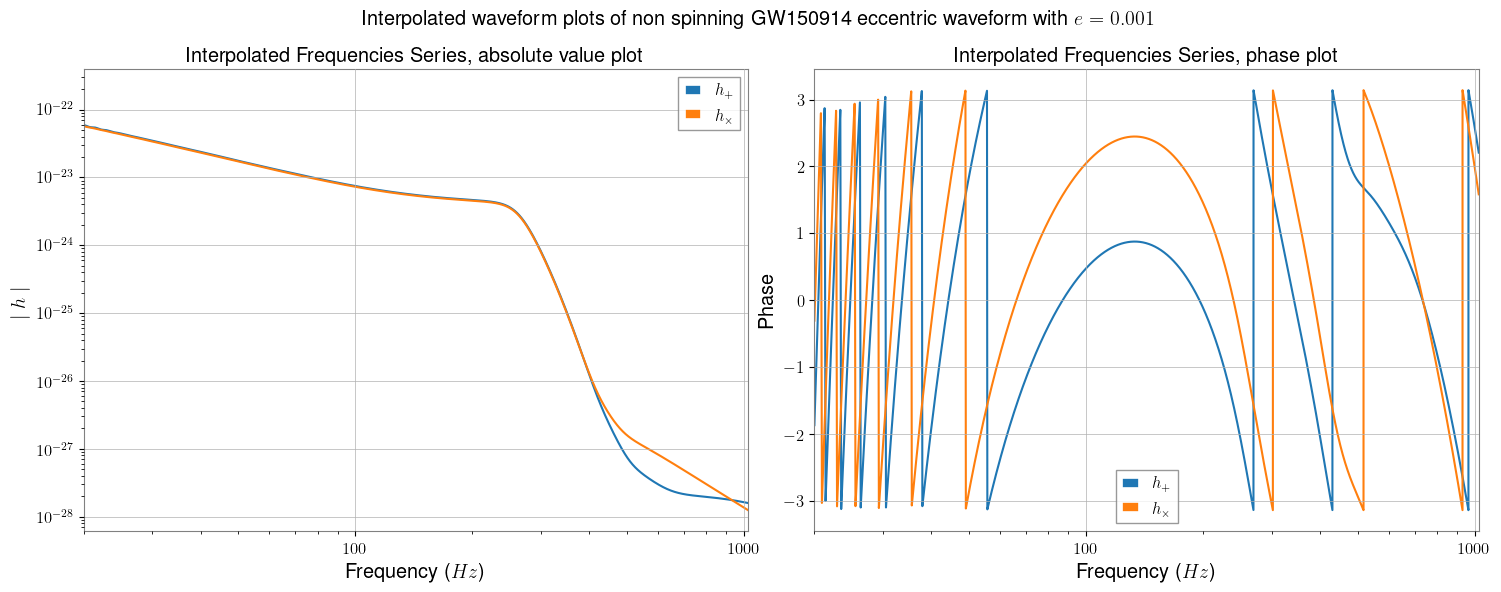

In [44]:
plt.show()

In [47]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(frequency_vector, np.abs(interpolated['plus']), label=r'$cyclic shift = 0$', color= 'black')
sub_figure_1.loglog(frequency_vector, np.abs(interpolated_v2['plus']), label=r'$cyclic shift = 0.08984375$', color= 'red', linestyle='dashed')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(frequency_vector, np.angle(interpolated['plus']), label=r'$cyclic shift = 0$', color='black')
sub_figure_2.plot(frequency_vector, np.angle(interpolated_v2['plus']), label=r'$cyclic shift = 0.08984375$', color='red')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Checking the difference between the frequency series waveforms, when they undergo cyclic time shift')

Text(0.5, 0.98, 'Checking the difference between the frequency series waveforms, when they undergo cyclic time shift')

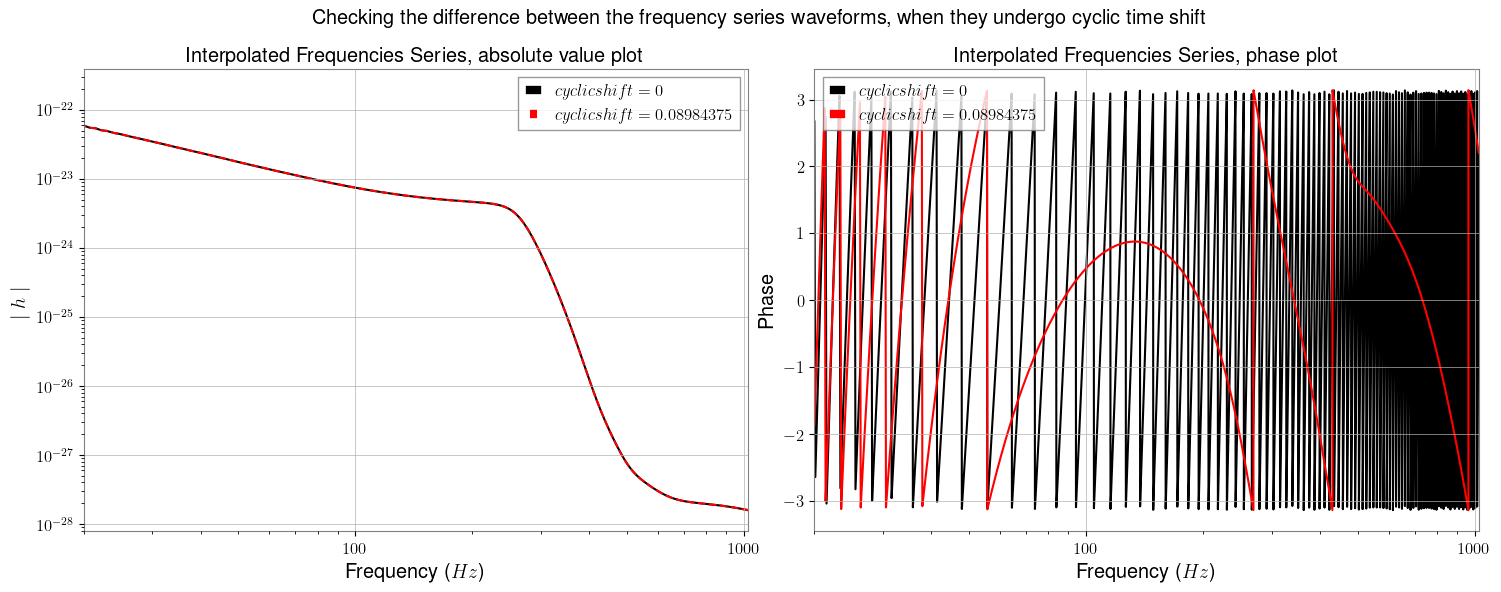

In [48]:
plt.show()